In [2]:
!pip install --upgrade transformers
!pip install --upgrade datasets evaluate

  Using cached datasets-4.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached evaluate-0.4.6-py3-none-any.whl.metadata (9.5 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; 

# Data Preparation and Preprocessing

In [3]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_excel(fn)

df.head()

Saving AMAZON REVIEW RATING.xlsx to AMAZON REVIEW RATING.xlsx


,Rating,Title,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [4]:
df['Review'] = df['Review'].astype(str).apply(lambda x: x.lower())
display(df.head())

,Rating,Title,Review
0,3,more like funchuck,gave this to my dad for a gag gift after direc...
1,5,Inspiring,i hope a lot of people hear this cd. we need m...
2,5,The best soundtrack ever to anything.,i'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,the music of yasunori misuda is without questi...
4,5,Too good to be true,probably the greatest soundtrack in history! u...


In [5]:
import re
import nltk
from google.colab import files
import io
import pandas as pd

# Download stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords

stopwords_english = set(stopwords.words('english'))

# Upload Tagalog stop words file if it hasn't been uploaded yet
if 'uploaded_tagalog' not in locals():
    print("Please upload the Tagalog stop words file.")
    uploaded_tagalog = files.upload()

stopwords_tagalog = set()
for fn in uploaded_tagalog.keys():
    content = uploaded_tagalog[fn]
    stopwords_tagalog.update(content.decode('utf-8').splitlines())

# Combine English and Tagalog stop words
all_stopwords = stopwords_english.union(stopwords_tagalog)


def normalize_spaces(s):
    s = str(s).replace('\u200b', ' ') # Ensure input is string
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

def replace_urls_emails_phones(text):
    text = re.sub(r'https?://\S+|www\.\S+', ' <url> ', text)
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', ' <email> ', text)
    text = re.sub(r'\b(\+?\d[\d\s\-]{7,}\d)\b', ' <phone> ', text)
    return text

def collapse_elongations(text):
    # coooool -> coool; soooo -> soo; hahahaha -> haha
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

def remove_low_signal(text):
    # remove extraneous punctuation runs but keep single punctuation
    text = re.sub(r'[^\w\s!?.,:@<>]', ' ', text)   # drop emojis/symbols
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

boiler_patterns = re.compile(
    r'^(|none|n/a|na|null|wala|wala na|wala naman|no|no comment|none po|none nmn|nothing|\.)$',
    re.IGNORECASE
)

def is_boilerplate(s):
    t = str(s).lower().strip() # Ensure input is string
    t = re.sub(r'\s+', ' ', t)
    return bool(boiler_patterns.match(t)) or len(t) <= 1

# Main cleaning function
def clean_suggestion(text):
    if pd.isna(text) or is_boilerplate(text):
        return None

    x = str(text).lower()
    # Remove stopwords first
    x_no_stopwords = ' '.join([word for word in x.split() if word not in all_stopwords])

    # Apply other cleaning steps
    x_cleaned = normalize_spaces(x_no_stopwords)
    x_cleaned = replace_urls_emails_phones(x_cleaned)
    x_cleaned = collapse_elongations(x_cleaned)
    x_cleaned = remove_low_signal(x_cleaned) # Keeping minimal punctuation as per previous code

    return x_cleaned.strip()

# Apply the cleaning function to the 'Review' column to create the single cleaned column
df['cleaned_review_final'] = df['Review'].apply(lambda x: clean_suggestion(x))

# Remove duplicate rows based on the cleaned reviews
df.drop_duplicates(subset=['cleaned_review_final'], inplace=True)

# Display the first few rows of the DataFrame with the new column
display(df.head())

Please upload the Tagalog stop words file.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Saving tagalog_stopwords (1).txt to tagalog_stopwords (1).txt


,Rating,Title,Review,cleaned_review_final
0,3,more like funchuck,gave this to my dad for a gag gift after direc...,"gave dad gag gift directing nunsense, got real..."
1,5,Inspiring,i hope a lot of people hear this cd. we need m...,hope lot people hear cd. need strong positive ...
2,5,The best soundtrack ever to anything.,i'm reading a lot of reviews saying that this ...,reading lot reviews saying best game soundtrac...
3,4,Chrono Cross OST,the music of yasunori misuda is without questi...,music yasunori misuda without question close s...
4,5,Too good to be true,probably the greatest soundtrack in history! u...,probably greatest soundtrack history! usually ...


In [6]:
df = df.dropna().reset_index(drop=True)

In [7]:
from google.colab import files
import pandas as pd

# Define the filename
output_filename = 'AMAZON_REVIEW_RATING.csv'

# Save the transformed DataFrame to a CSV file, including the final cleaned column and the ground_truth column
df[['cleaned_review_final', 'Rating']].to_csv(output_filename, index=False)

# Download the file
files.download(output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Upload the transformed dataset with GROUND TRUTH

In [8]:
# Upload the final dataset with ground truth for evaluation
from google.colab import files
import pandas as pd

uploaded = files.upload()

for fn in uploaded.keys():
  df = pd.read_csv(fn)

# Adjust 'Rating' column to be 0-indexed
df['Rating'] = df['Rating'] - 1

df.head()

Saving AMAZON_REVIEW_RATING.csv to AMAZON_REVIEW_RATING (1).csv


,cleaned_review_final,Rating
0,"gave dad gag gift directing nunsense, got real...",2
1,hope lot people hear cd. need strong positive ...,4
2,reading lot reviews saying best game soundtrac...,4
3,music yasunori misuda without question close s...,3
4,probably greatest soundtrack history! usually ...,4


<Axes: title={'center': 'Distribution of Rating Labels'}, xlabel='Rating'>

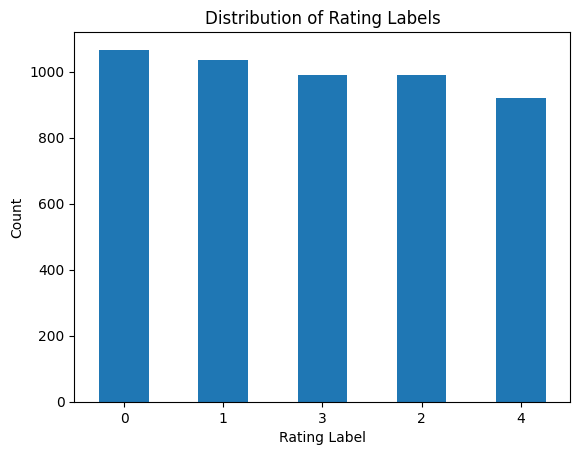

In [9]:
import matplotlib.pyplot as plt

# Display the class distribution of the 'Rating' column
display(df['Rating'].value_counts().plot(kind='bar', title='Distribution of Rating Labels'))
plt.xlabel('Rating Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# SETTING UP THE BERT EVALUATION

In [10]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

train_val_dataset, test_dataset = train_test_split(df, test_size=0.1, random_state=42)

train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

In [11]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset['Rating']),
    y=train_dataset['Rating']
)

# Convert class weights to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.9213828425096031), 1: np.float64(0.9777173913043479), 2: np.float64(1.025071225071225), 3: np.float64(0.9844049247606019), 4: np.float64(1.1104938271604938)}


# MODEL (distilbert-base-multilingual-cased)

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DistilBertTokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

def tokenize_function(examples):
    # Convert all items to string to prevent TypeError
    # This handles cases where the column might contain None, NaN, etc.
    texts = [str(text) for text in examples["cleaned_review_final"]]

    tokenized = DistilBertTokenizer(
        texts,  # Use the sanitized list of strings
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["Rating"]
    return tokenized

# Now, run your mapping again
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

DistilBertModel = AutoModelForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=5)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/3598 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Define the Hyperparameter Search Space

In [13]:
# This function defines the search space for Optuna
def hp_space_optuna(trial):
    return {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.0, 0.01, 0.1]),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 200, 500]),
    }

# Add functions

In [23]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
import numpy as np
import evaluate

# --- 1. Define the Metric Computation ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1_metric = evaluate.load("f1")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {"f1": f1["f1"], "accuracy": accuracy["accuracy"]}

# --- 2. Define the Corrected Custom Weighted Loss Trainer ---
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure class_weights_dict is defined and accessible
        # This code assumes 'class_weights_dict' is in the global scope
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values()), device=logits.device, dtype=logits.dtype))

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 3. Define the Model Initializer for the Search ---
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-multilingual-cased',
        num_labels=5 # Changed num_labels from 3 to 5
    )

print("Helper functions and the corrected WeightedLossTrainer class are now defined.")

Helper functions and the corrected WeightedLossTrainer class are now defined.


In [15]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.8 MB/s eta 0:00:00


# Perform Grid Search

In [16]:
import torch
import numpy as np
import evaluate
import optuna
from math import ceil
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification,
    AutoTokenizer
)

# --- 1. Define Training Arguments ---
# We add `report_to="none"` to prevent the Trainer from trying to log in
# to external services like Weights & Biases or the Hugging Face Hub.
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",  # This line prevents the API key prompt.
    disable_tqdm=False,
)

# --- 2. Initialize the Trainer ---
trainer = WeightedLossTrainer(
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    model_init=model_init,
    tokenizer=DistilBertTokenizer
)

# --- 3. Execute the Grid Search ---
print("--- Starting Grid Search ---")
print("⚠️ WARNING: If the run results in a perfect F1 score of 1.0,")
print("it may suggest data leakage (e.g., validation set is the same as training set).")
print("Please verify your data splitting and preprocessing steps.")

best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space_optuna,
    n_trials=27, # 3*3*3 = 27 trials for a full grid search
    sampler=optuna.samplers.GridSampler({
        "per_device_train_batch_size": [8, 16, 32],
        "weight_decay": [0.0, 0.01, 0.1],
        "warmup_steps": [0, 200, 500]
    })
)

# --- 4. Print the Results ---
print("\n--- Grid Search Complete ---")
print("Best trial results:")
print(f"Objective (F1-Score): {best_run.objective:.4f}")
print("Best Hyperparameters:")
for param, value in best_run.hyperparameters.items():
    print(f"  {param}: {value}")

/tmp/ipython-input-1768050788.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-08 11:01:16,858] A new study created in memory with name: no-name-b30afc7f-4999-4850-ace3-e36a8392aca3


--- Starting Grid Search ---
⚠️ WARNING: If the run results in a perfect F1 score of 1.0,
it may suggest data leakage (e.g., validation set is the same as training set).
Please verify your data splitting and preprocessing steps.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.430563,0.301435
2,1.450500,1.347169,0.437114
3,1.130400,1.478525,0.438531


[I 2025-11-08 11:04:52,769] Trial 0 finished with value: 0.4385307333263965 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.1, 'warmup_steps': 0}. Best is trial 0 with value: 0.4385307333263965.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.571731,0.308128
2,No log,1.379096,0.357370
3,No log,1.319883,0.454724


[I 2025-11-08 11:07:49,228] Trial 1 finished with value: 0.45472445720656474 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.0, 'warmup_steps': 500}. Best is trial 1 with value: 0.45472445720656474.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.482858,0.283535
2,No log,1.338581,0.434956
3,1.363900,1.414590,0.438607


[I 2025-11-08 11:11:21,042] Trial 2 finished with value: 0.4386066013745977 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.1, 'warmup_steps': 200}. Best is trial 1 with value: 0.45472445720656474.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.491334,0.259391
2,No log,1.366453,0.394456
3,1.429600,1.342570,0.454714


[I 2025-11-08 11:14:33,020] Trial 3 finished with value: 0.4547143262881218 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.1, 'warmup_steps': 500}. Best is trial 1 with value: 0.45472445720656474.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.422804,0.315514
2,1.474000,1.327720,0.436374
3,1.139100,1.466233,0.448376


[I 2025-11-08 11:18:02,469] Trial 4 finished with value: 0.4483757879167605 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.1, 'warmup_steps': 200}. Best is trial 1 with value: 0.45472445720656474.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.450802,0.301485
2,No log,1.327214,0.426091
3,1.301500,1.425049,0.440806


[I 2025-11-08 11:21:05,764] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.544215,0.243247


[I 2025-11-08 11:21:47,308] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.519594,0.282834
2,No log,1.329229,0.427052
3,1.363900,1.429595,0.438864


[I 2025-11-08 11:24:55,574] Trial 7 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.448463,0.320593
2,No log,1.315020,0.425334
3,No log,1.366934,0.428824


[I 2025-11-08 11:27:27,335] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.457285,0.312548
2,No log,1.317943,0.426011
3,No log,1.368015,0.428096


[I 2025-11-08 11:30:21,929] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.490071,0.267221


[I 2025-11-08 11:31:08,430] Trial 10 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.422936,0.301869


[I 2025-11-08 11:32:04,230] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.452476,0.307131
2,No log,1.350126,0.422680
3,1.294200,1.450531,0.426819


[I 2025-11-08 11:35:13,137] Trial 12 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.571317,0.312994
2,No log,1.381806,0.352697


[I 2025-11-08 11:36:53,822] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.571687,0.308369
2,No log,1.376791,0.361133
3,No log,1.319519,0.452406


[I 2025-11-08 11:39:52,251] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.458766,0.314552


[I 2025-11-08 11:40:47,926] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.488398,0.303680


[I 2025-11-08 11:41:43,755] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.433274,0.312230


[I 2025-11-08 11:42:39,456] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.447428,0.318531
2,No log,1.317534,0.422847
3,No log,1.366166,0.425190


[I 2025-11-08 11:46:45,973] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.434441,0.309752
2,No log,1.342914,0.410421
3,1.298700,1.454992,0.436949


[I 2025-11-08 11:52:00,124] Trial 19 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.473547,0.323641


[I 2025-11-08 11:52:55,728] Trial 20 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.538826,0.261641


[I 2025-11-08 11:53:37,610] Trial 21 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.428021,0.309631


[I 2025-11-08 11:54:33,231] Trial 22 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.387811,0.356657
2,1.461400,1.347216,0.444280
3,1.155600,1.475327,0.438838


[I 2025-11-08 12:01:46,784] Trial 23 finished with value: 0.4388383552100462 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.0, 'warmup_steps': 0}. Best is trial 1 with value: 0.45472445720656474.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.537106,0.265368


[I 2025-11-08 12:02:28,949] Trial 24 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.486530,0.267452


[I 2025-11-08 12:03:15,619] Trial 25 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.566579,0.267253


[I 2025-11-08 12:04:02,551] Trial 26 pruned. 



--- Grid Search Complete ---
Best trial results:
Objective (F1-Score): 0.4547
Best Hyperparameters:
  per_device_train_batch_size: 32
  weight_decay: 0.0
  warmup_steps: 500


#Perform Random Search

In [18]:
import torch
import numpy as np
import evaluate
import optuna
from transformers import (
    TrainingArguments,
    Trainer,
    AutoModelForSequenceClassification
)

# --- 2. Define Helper Functions and the Corrected Custom Trainer ---

def compute_metrics(eval_pred):
    """Computes weighted F1 score and accuracy for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1_metric = evaluate.load("f1")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')

    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)

    return {"f1": f1["f1"], "accuracy": accuracy["accuracy"]}

class WeightedLossTrainer(Trainer):
    """Custom trainer that applies class weights to the loss function."""
    # The **kwargs fixes the 'unexpected keyword argument' TypeError.
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Create a CrossEntropyLoss function with the pre-calculated weights
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(
                list(class_weights_dict.values()),
                device=logits.device,
                dtype=logits.dtype
            )
        )

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def model_init(trial):
    """Initializes a new model for each Optuna trial."""
    return AutoModelForSequenceClassification.from_pretrained(
        'distilbert-base-multilingual-cased',
        num_labels=5 # This must match the number of classes in class_weights_dict
    )

# --- 3. Define the Hyperparameter Search Space for Random Search ---
def optuna_hp_space(trial):
    """Defines the hyperparameter space for Optuna to randomly sample from."""
    return {
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        # suggest_float is better for random search than a fixed list of choices
        "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3, log=True),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 200, 500]),
    }

# --- 4. Set up Training Arguments with Disk Space Management ---
training_args_random = TrainingArguments(
    output_dir='./distilbert-random-search',
    num_train_epochs=3,
    per_device_eval_batch_size=16,
    logging_dir='./random-search-logs',
    logging_steps=50,
    # Using older argument names for max compatibility
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # --- THIS IS THE FIX FOR THE "DISK FULL" ERROR ---
    save_total_limit=1, # Only keeps the single best checkpoint, deleting older ones.
    report_to="none",
    disable_tqdm=False
)

# --- 5. Initialize the Trainer ---
trainer_random = WeightedLossTrainer(
    args=training_args_random,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    model_init=model_init
    # Note: The 'tokenizer' argument is correctly omitted to prevent errors.
)

# --- 6. Execute the Random Search ---
print("-- Starting Random Search ---")

# n_trials specifies how many different hyperparameter combinations to test.
# 20-30 is a good number for a comprehensive search.
best_run_random = trainer_random.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=20
    # By not providing a 'sampler', we let Optuna use its default, efficient sampler.
)

print("\n--- Random Search Complete ---")
print("Best trial results:")
print(f"Objective (F1-Score): {best_run_random.objective}")
print("Best Hyperparameters:")
for param, value in best_run_random.hyperparameters.items():
    print(f"  {param}: {value}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-11-08 12:05:23,086] A new study created in memory with name: no-name-affed9b9-c9f3-476e-a8a5-f04e40e8559a


-- Starting Random Search ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.393100,1.420093,0.302107
2,1.209900,1.339112,0.441463
3,0.860800,1.470999,0.451887


Epoch,Training Loss,Validation Loss,F1
1,1.393100,1.420093,0.302107
2,1.209900,1.339112,0.441463
3,0.860800,1.470999,0.451887


[I 2025-11-08 12:13:27,043] Trial 0 finished with value: 0.45188745816617054 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.16065426323716905, 'warmup_steps': 200}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.430500,1.463764,0.294920
2,1.222600,1.321302,0.421312
3,1.052500,1.372166,0.420312


[I 2025-11-08 12:19:45,305] Trial 1 finished with value: 0.4203119379786383 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.05943120006846961, 'warmup_steps': 0}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.386200,1.403738,0.330721
2,1.193800,1.339462,0.452708
3,0.835800,1.464366,0.435978


[I 2025-11-08 12:26:29,866] Trial 2 finished with value: 0.43597835224078973 and parameters: {'per_device_train_batch_size': 8, 'weight_decay': 0.10855879281520453, 'warmup_steps': 0}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.409400,1.424032,0.313443
2,1.195300,1.342302,0.402182
3,0.861600,1.430411,0.425007


[I 2025-11-08 12:32:03,682] Trial 3 finished with value: 0.4250074083648806 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.25198693951126017, 'warmup_steps': 0}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.537200,1.483841,0.269324
2,1.375400,1.370273,0.397688
3,1.048300,1.331948,0.443970


[I 2025-11-08 12:38:10,481] Trial 4 finished with value: 0.4439700108648485 and parameters: {'per_device_train_batch_size': 16, 'weight_decay': 0.26309819473846086, 'warmup_steps': 500}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.463300,1.528863,0.278529


[I 2025-11-08 12:38:57,273] Trial 5 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.409900,1.457291,0.296256


[I 2025-11-08 12:39:52,496] Trial 6 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.430100,1.457678,0.310229
2,1.220700,1.313993,0.424210
3,1.052000,1.364644,0.423462


[I 2025-11-08 12:44:15,788] Trial 7 finished with value: 0.4234624009710765 and parameters: {'per_device_train_batch_size': 32, 'weight_decay': 0.01629161088132773, 'warmup_steps': 0}. Best is trial 0 with value: 0.45188745816617054.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.600200,1.571779,0.313578
2,1.463300,1.381300,0.362467


[I 2025-11-08 12:47:43,426] Trial 8 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.574100,1.542650,0.246065


[I 2025-11-08 12:48:24,801] Trial 9 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.413300,1.447917,0.318497


[I 2025-11-08 12:49:20,311] Trial 10 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.537000,1.482725,0.276851


[I 2025-11-08 12:50:06,864] Trial 11 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.536700,1.490095,0.261605


[I 2025-11-08 12:50:53,328] Trial 12 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.420200,1.461772,0.308976


[I 2025-11-08 12:51:48,876] Trial 13 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.404400,1.411712,0.333697


[I 2025-11-08 12:52:44,406] Trial 14 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.537500,1.482896,0.278010


[I 2025-11-08 12:53:30,851] Trial 15 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.535900,1.491659,0.262951


[I 2025-11-08 12:54:17,147] Trial 16 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.382900,1.399604,0.348859


[I 2025-11-08 12:55:12,587] Trial 17 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.396200,1.404519,0.361568


[I 2025-11-08 12:56:08,255] Trial 18 pruned. 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,1.537400,1.482303,0.271716


[I 2025-11-08 12:56:54,544] Trial 19 pruned. 



--- Random Search Complete ---
Best trial results:
Objective (F1-Score): 0.45188745816617054
Best Hyperparameters:
  per_device_train_batch_size: 8
  weight_decay: 0.16065426323716905
  warmup_steps: 200


### Grid Search Results

In [19]:
print("--- Grid Search Results ---")
print(f"Objective (F1-Score): {best_run.objective:.4f}")
print("Best Hyperparameters:")
for param, value in best_run.hyperparameters.items():
    print(f"  {param}: {value}")

--- Grid Search Results ---
Objective (F1-Score): 0.4547
Best Hyperparameters:
  per_device_train_batch_size: 32
  weight_decay: 0.0
  warmup_steps: 500


### Random Search Results

In [20]:
print("--- Random Search Results ---")
print(f"Objective (F1-Score): {best_run_random.objective:.4f}")
print("Best Hyperparameters:")
for param, value in best_run_random.hyperparameters.items():
    print(f"  {param}: {value}")

--- Random Search Results ---
Objective (F1-Score): 0.4519
Best Hyperparameters:
  per_device_train_batch_size: 8
  weight_decay: 0.16065426323716905
  warmup_steps: 200


In [21]:
import pandas as pd

# Prepare data for Grid Search results
grid_search_results = {
    'Search Type': 'Grid Search',
    'Objective (F1-Score)': best_run.objective,
    'per_device_train_batch_size': best_run.hyperparameters.get('per_device_train_batch_size'),
    'weight_decay': best_run.hyperparameters.get('weight_decay'),
    'warmup_steps': best_run.hyperparameters.get('warmup_steps')
}

# Prepare data for Random Search results
random_search_results = {
    'Search Type': 'Random Search',
    'Objective (F1-Score)': best_run_random.objective,
    'per_device_train_batch_size': best_run_random.hyperparameters.get('per_device_train_batch_size'),
    'weight_decay': best_run_random.hyperparameters.get('weight_decay'),
    'warmup_steps': best_run_random.hyperparameters.get('warmup_steps')
}

# Create a DataFrame from the results
results_df = pd.DataFrame([grid_search_results, random_search_results])

# Display the DataFrame
display(results_df)


,Search Type,Objective (F1-Score),per_device_train_batch_size,weight_decay,warmup_steps
0,Grid Search,0.454724,32,0.000000,500
1,Random Search,0.451887,8,0.160654,200


In [22]:
from google.colab import files

output_excel_filename = 'hyperparameter_search_results.xlsx'
results_df.to_excel(output_excel_filename, index=False)

print(f"Results saved to {output_excel_filename}")
files.download(output_excel_filename)

Results saved to hyperparameter_search_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>